In [1]:
from asammdf import MDF

# Load your .mf4 file
mdf = MDF("Vehicle01_meas4.mf4")  # Replace with your filename

# Print all signal names available in the file
print("Available signals:")
for signal in mdf.channels_db:
    print(signal)

# Read specific signals
battery_voltage = mdf.get("Eng_uBatt")         # Battery voltage in mV
fuel_pressure   = mdf.get("FuSHp_pRailBnk1")   # Fuel pressure
engine_speed    = mdf.get("Eng_nEng10ms")      # Engine speed

# Access time and signal values
print("Battery voltage timestamps:", battery_voltage.timestamps)
print("Battery voltage samples:", battery_voltage.samples)


Available signals:
time
FuSHp_pCtlBnk1
Veh_bSailEna
Eng_bMisfFirstIntlCyc
Eng_ctMisfCatThd
Eng_ctMisfEmiThd
Eng_tqAlt
Air_bSensVld_pEnv
Air_pMeanTolSensBnk1
Air_pMeanVldSig
Air_tInBnk1
Air_TInMnfBnk1
Eng_AddLamAdpn_Bnk1
Eng_bIdl
Eng_bLamAdpnAdd_Bnk1
Eng_bLamAdpnAddFinCyc_Bnk1
Eng_bLamAdpnFac_Bnk1
Eng_bLamAdpnFac_Fu2Bnk1
Eng_bLamAdpnFacFinCyc_Bnk1
Eng_bLamAdpnFailSusp
Eng_bLamAdpnStabAdd_Bnk1
Eng_bLamAdpnStabFac_Fu2Bnk1
Eng_facAdpnPurgeTnk
Eng_FacLamAdpn_Bnk1
Eng_FacLamAdpn_Fu2Bnk1
Eng_tCo
Eng_tCoRaw
Eng_tCoStopFirst
Eng_tCoStrtFirst
Eng_tCoStrtFirstRaw
Eng_tiAftFirstStrt
Eng_tiAftStrt
Eng_tOilSwmpRaw
Exh_bSens1RdyBnk1
Exh_facAftCatAdpnBnk1
Exh_facOscCatBnk1
Exh_mOxiCat1Bnk1
Exh_resElmtSens2Bnk1
FuSHp_bDiagPinPntEna
FuSHp_bDiagVlvStuckClsEna
FuSHp_bDiagVlvStuckOpEna
FuSLp_pSp
Veh_bMil
Veh_facAlti
Veh_pEnv
Veh_pEnvRaw
Veh_tEnv
Veh_tiDiagRefEngOff
Veh_tiDifDiagEngOff
Air_bChk_pInMnfBnk1
Air_pInMnfMdlFilMaxBnk1
Air_pInMnfMdlFilMinBnk1
Air_pInMnfRawFilMaxBnk1
Air_pInMnfRawFilMinBnk1
Disp_ds

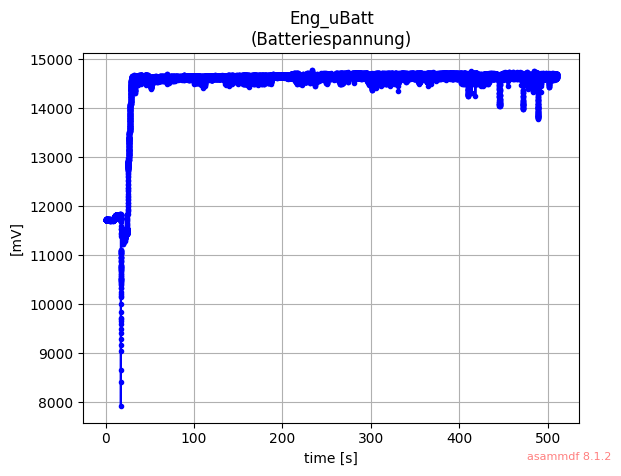

In [2]:
battery_voltage.plot()


In [3]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load fine-tuned model and tokenizer
model_path = "./flan-t5-visualization"
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

# Inference function
def predict(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model.generate(**inputs, max_length=64)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example
query = "ok now I want you to plot a nice histogram for battery voltage "
result = predict(query)
print("Prediction:", result)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Prediction: 'Method': 'histogram', 'Attribute': 'Eng_uBatt'


In [4]:
!pip install fastapi uvicorn python-multipart asammdf transformers torch matplotlib pandas

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import os
from fastapi import FastAPI, UploadFile, Form, File
from fastapi.responses import JSONResponse, FileResponse
from asammdf import MDF
from transformers import T5Tokenizer, T5ForConditionalGeneration
import pandas as pd
import matplotlib.pyplot as plt
import torch
import uuid
import re
import numpy as np

app = FastAPI()

# Load model once
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
model = T5ForConditionalGeneration.from_pretrained("flan-t5-visualization")

UPLOAD_DIR = "uploads"
os.makedirs(UPLOAD_DIR, exist_ok=True)

def parse_user_query(user_query: str):
    try:
        input_ids = tokenizer(user_query, return_tensors="pt").input_ids
        output = model.generate(input_ids, max_length=64)
        decoded = tokenizer.decode(output[0], skip_special_tokens=True)
        print(decoded)
        return decoded
    except:
        return None
    
def parse_output_string(s):
    matches = re.findall(r"'(\w+)'\s*:\s*'([^']+)'", s)
    return {k: v for k, v in matches}

def extract_signal(mdf_path, signal_name):
    try:
        mdf = MDF(mdf_path)
        signal = mdf.get(signal_name)
        df = pd.DataFrame({
            'timestamp': signal.timestamps,
            'value': signal.samples
})
        return df
    except Exception as e:
        print(f"[ERROR] Signal '{signal_name}' not found: {e}")
        return None

def generate_plot_and_stats(df, attribute, method):
    data = df["value"]
    time = df["timestamp"]

    # Compute duration between samples
    if len(time) > 1:
        time_deltas = time.diff().fillna(0)
    else:
        time_deltas = [1] * len(data)  # fallback if only one point

    summary = {
        "mean": round(data.mean(), 3),
        "median": round(data.median(), 3),
        "std": round(data.std(), 3),
        "min": round(data.min(), 3),
        "max": round(data.max(), 3)
    }

    filename = f"{uuid.uuid4().hex}.png"
    filepath = os.path.join("uploads", filename)

    plt.figure(figsize=(10, 6))
    method = method.lower()

    if method == "histogram":
        # Bin edges
        bins = 50
        bin_values, bin_edges = np.histogram(data, bins=bins)

        # Map each value to its bin duration using time_deltas
        bin_indices = np.digitize(data, bin_edges[:-1], right=False)
        duration_per_bin = [0] * bins

        for i in range(len(data)):
            idx = bin_indices[i] - 1
            if 0 <= idx < bins:
                duration_per_bin[idx] += time_deltas.iloc[i]

        # Plot duration vs. bin centers
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.bar(bin_centers, duration_per_bin, width=bin_edges[1]-bin_edges[0], edgecolor='black', color='skyblue')
        plt.ylabel("Duration [s]")

    elif method == "line plot":
        plt.plot(time, data, color='blue')
        plt.xlabel("Time [s]")
        plt.ylabel(attribute)

    elif method == "bar chart":
        data.plot(kind='bar', color='orange')
        plt.ylabel(attribute)

    elif method == "scatter plot":
        plt.scatter(time, data, alpha=0.6)
        plt.xlabel("Time [s]")
        plt.ylabel(attribute)

    elif method == "box plot":
        plt.boxplot(data)
        plt.ylabel(attribute)

    else:
        return None, None

    plt.title(f"{method.title()} of {attribute}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filepath)
    plt.close()

    return summary, filepath


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
query = "plot a nice histogram of battery volatage"
parsed = parse_user_query(query)

parsed = parse_output_string(parsed)
print(parsed)

'Method': 'histogram', 'Attribute': 'Eng_uBatt'
{'Method': 'histogram', 'Attribute': 'Eng_uBatt'}


In [16]:
if not parsed or "Method" not in parsed or "Attribute" not in parsed:
    print(JSONResponse({"error": "Could not interpret query"}, status_code=400))
else: print("done")

done


In [17]:
filepath = "Vehicle01_meas4.mf4"
df = extract_signal(filepath, parsed["Attribute"])

In [18]:
summary, plot_path = generate_plot_and_stats(df, parsed["Attribute"], parsed["Method"])